In [7]:
weights_sgd = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], mean=0.0, stddev=0.039)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.055)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], mean=0.0, stddev=0.120))  # 128x10
}

weights_relu = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], mean=0.0, stddev=0.062)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.125)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], mean=0.0, stddev=0.120))  # 128x10
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),  # 512
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),  # 128
    'out': tf.Variable(tf.random.normal([n_classes]))   # 10
}


# Model 1: input (784) - sigmoid(512) - sigmoid(128) - softmax(output 10) 

## Adam Optimizer

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1

# Weight and bias initialization
# weights for SGD / sigmoid or your original stddev values
weights_sgd = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.039, mean=0.0)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.055, mean=0.0)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) # 128x10
}

# He Normal initialization weights for ReLU later
weights_relu = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) # 128x10
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# MLP model
@tf.function
def multilayer_perceptron(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out']), biases['out']))
    return out_layer

# Optimizer and loss
optimizer = tf.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy function
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Plotting function
def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

fig, ax = plt.subplots(1, 1)
plt.ion()

xs, ytrs, ytes = [], [], []

for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron(batch_x)
            loss = loss_fn(batch_y, logits)
        gradients = tape.gradient(loss, list(weights_sgd.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights_sgd.values()) + list(biases.values())))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)
    test_logits = multilayer_perceptron(mnist_test_images)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if epoch % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

# Final static plot
plt.ioff()
plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
             title="MLP: Sigmoid(512)-Sigmoid(128)-Sigmoid(Output)-Adam")

# Final accuracy
final_logits = multilayer_perceptron(mnist_test_images)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())



C:\Users\Avani\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['Variable:0', 'Variable:0', 'Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 01, Train Loss: 0.4533, Test Loss: 0.4131
Epoch 02, Train Loss: 0.3762, Test Loss: 0.3494
Epoch 03, Train Loss: 0.3209, Test Loss: 0.3031
Epoch 04, Train Loss: 0.2804, Test Loss: 0.2688
Epoch 05, Train Loss: 0.2499, Test Loss: 0.2430
Epoch 06, Train Loss: 0.2267, Test Loss: 0.2231
Epoch 07, Train Loss: 0.2087, Test Loss: 0.2077
Epoch 08, Train Loss: 0.1946, Test Loss: 0.1955
Epoch 09, Train Loss: 0.1833, Test Loss: 0.1859
Epoch 10, Train Loss: 0.1742, Test Loss: 0.1781
Epoch 11, Train Loss: 0.1669, Test Loss: 0.1717
Epoch 12, Train Loss: 0.1608, Test Loss: 0.1665
Epoch 13, Train Loss: 0.1557, Test Loss: 0.1622
Epoch 14, Train Loss: 0.1514, Test Loss: 0.1585
Epoch 15, Train Loss: 0.1477, Test Loss: 0.1553
Test Accuracy: 0.9607


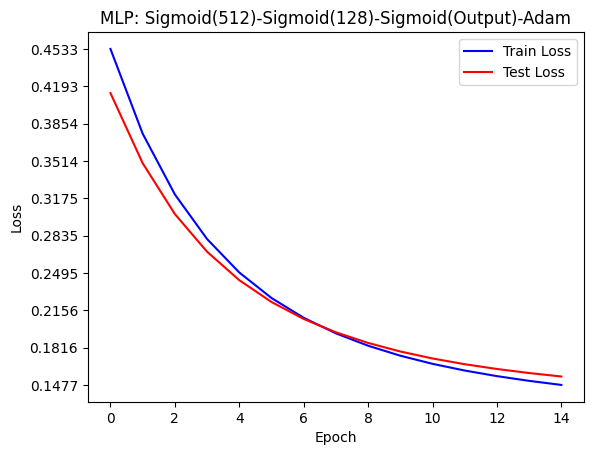

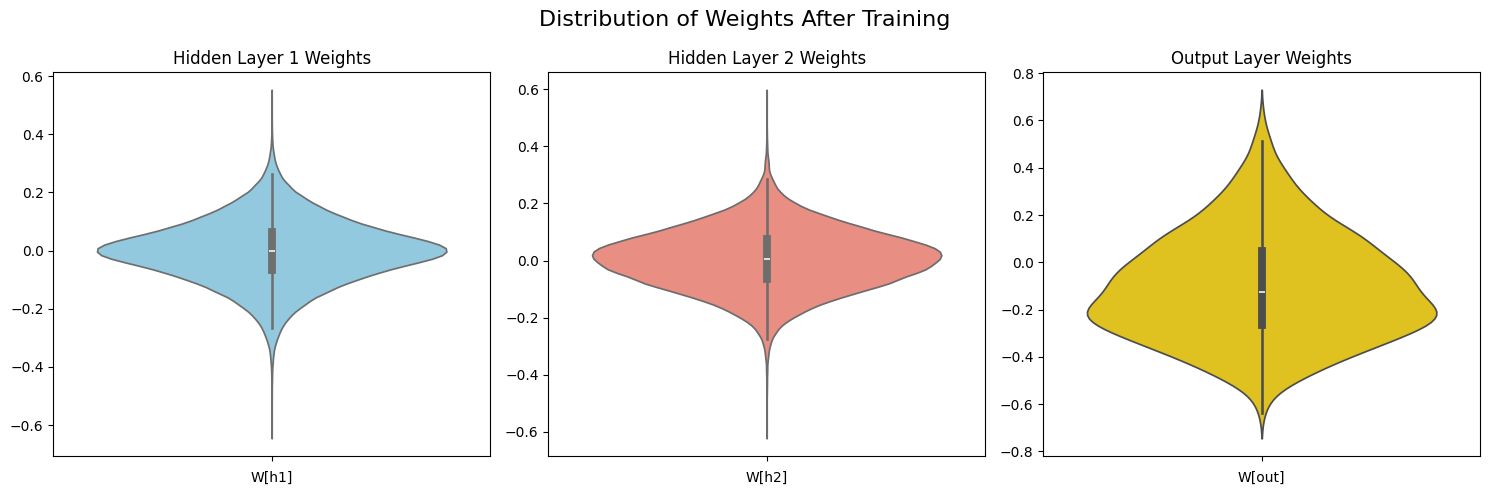

In [19]:

# Plot weight distributions
h1_w = weights['h1'].numpy().flatten()
h2_w = weights['h2'].numpy().flatten()
out_w = weights['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

## Optimizer SGD

C:\Users\Avani\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['Variable:0', 'Variable:0', 'Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 01, Train Loss: 0.4174, Test Loss: 0.4197
Epoch 02, Train Loss: 0.4158, Test Loss: 0.4181
Epoch 03, Train Loss: 0.4142, Test Loss: 0.4165
Epoch 04, Train Loss: 0.4126, Test Loss: 0.4150
Epoch 05, Train Loss: 0.4110, Test Loss: 0.4134
Epoch 06, Train Loss: 0.4094, Test Loss: 0.4119
Epoch 07, Train Loss: 0.4079, Test Loss: 0.4104
Epoch 08, Train Loss: 0.4063, Test Loss: 0.4088
Epoch 09, Train Loss: 0.4048, Test Loss: 0.4074
Epoch 10, Train Loss: 0.4033, Test Loss: 0.4059
Epoch 11, Train Loss: 0.4018, Test Loss: 0.4044
Epoch 12, Train Loss: 0.4003, Test Loss: 0.4029
Epoch 13, Train Loss: 0.3988, Test Loss: 0.4015
Epoch 14, Train Loss: 0.3974, Test Loss: 0.4001
Epoch 15, Train Loss: 0.3959, Test Loss: 0.3986
Test Accuracy: 0.8692


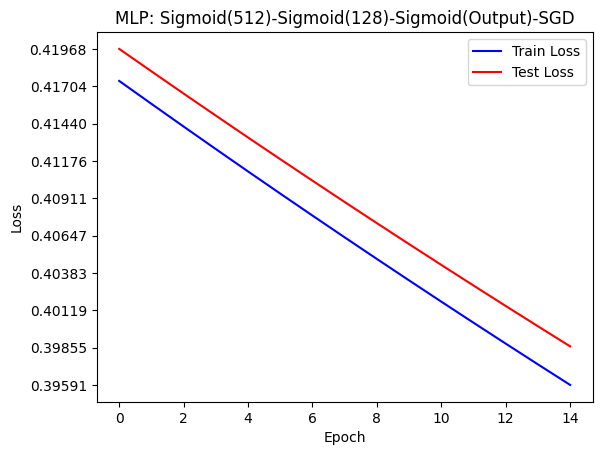

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1

# Weight and bias initialization
# weights for SGD / sigmoid or your original stddev values
weights_sgd = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.039, mean=0.0)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.055, mean=0.0)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) # 128x10
}

# He Normal initialization weights for ReLU later
weights_relu = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  # 784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)), # 512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) # 128x10
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# MLP model
@tf.function
def multilayer_perceptron(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out']), biases['out']))
    return out_layer

# Optimizer and loss
optimizer = tf.optimizers.SGD(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy function
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Plotting function
def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

fig, ax = plt.subplots(1, 1)
plt.ion()

xs, ytrs, ytes = [], [], []

for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron(batch_x)
            loss = loss_fn(batch_y, logits)
        gradients = tape.gradient(loss, list(weights_sgd.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights_sgd.values()) + list(biases.values())))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)
    test_logits = multilayer_perceptron(mnist_test_images)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if epoch % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

# Final static plot
plt.ioff()
plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
             title="MLP: Sigmoid(512)-Sigmoid(128)-Sigmoid(Output)-SGD")

# Final accuracy
final_logits = multilayer_perceptron(mnist_test_images)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())

plt.show()

# Model 2: input (784) - ReLu(512) - ReLu(128) - sigmoid(output 10)

## Adam

Epoch 01, Train Loss: 0.6286, Test Loss: 0.2246
Epoch 02, Train Loss: 0.1896, Test Loss: 0.1609
Epoch 03, Train Loss: 0.1338, Test Loss: 0.1339
Epoch 04, Train Loss: 0.1027, Test Loss: 0.1163
Epoch 05, Train Loss: 0.0827, Test Loss: 0.1018
Epoch 06, Train Loss: 0.0676, Test Loss: 0.0978
Epoch 07, Train Loss: 0.0592, Test Loss: 0.1002
Epoch 08, Train Loss: 0.0508, Test Loss: 0.0881
Epoch 09, Train Loss: 0.0413, Test Loss: 0.0805
Epoch 10, Train Loss: 0.0331, Test Loss: 0.0733
Epoch 11, Train Loss: 0.0272, Test Loss: 0.0778
Epoch 12, Train Loss: 0.0225, Test Loss: 0.0805
Epoch 13, Train Loss: 0.0196, Test Loss: 0.0914
Epoch 14, Train Loss: 0.0174, Test Loss: 0.0840
Epoch 15, Train Loss: 0.0154, Test Loss: 0.0769
Test Accuracy: 0.9783


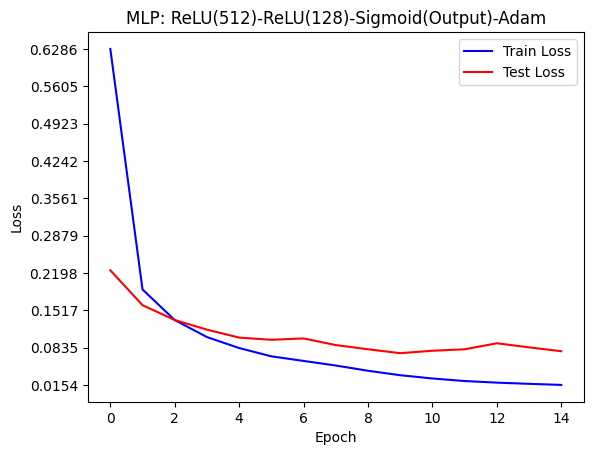

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1

# Weight and bias initialization
weights_sgd = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.039, mean=0.0)),  
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.055, mean=0.0)), 
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) 
}

weights_relu = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)), 
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) 
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# Use weights_relu for ReLU activations
weights = weights_relu

# MLP model with ReLU activations
@tf.function
def multilayer_perceptron(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out']), biases['out']))  # Keep sigmoid in output for classification probs
    return out_layer

# Optimizer and loss
optimizer = tf.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy function
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Plotting function
def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

fig, ax = plt.subplots(1, 1)
plt.ion()

xs, ytrs, ytes = [], [], []

for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron(batch_x)
            loss = loss_fn(batch_y, logits)
        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)
    test_logits = multilayer_perceptron(mnist_test_images)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if epoch % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

# Final static plot
plt.ioff()
plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
             title="MLP: ReLU(512)-ReLU(128)-Sigmoid(Output)-Adam")

# Final accuracy
final_logits = multilayer_perceptron(mnist_test_images)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

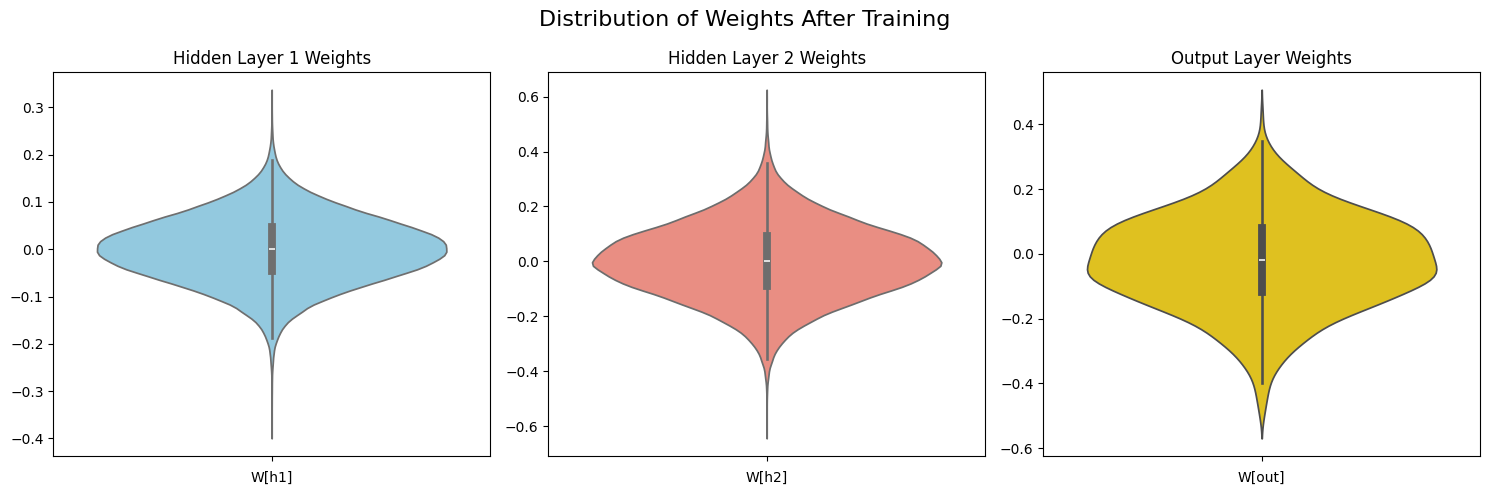

In [25]:

# Plot weight distributions
h1_w = weights_relu['h1'].numpy().flatten()
h2_w = weights_relu['h2'].numpy().flatten()
out_w = weights_relu['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

## SGD

Epoch 01, Train Loss: 2.6081, Test Loss: 2.4448
Epoch 02, Train Loss: 2.3701, Test Loss: 2.3395
Epoch 03, Train Loss: 2.3084, Test Loss: 2.3007
Epoch 04, Train Loss: 2.2812, Test Loss: 2.2791
Epoch 05, Train Loss: 2.2642, Test Loss: 2.2637
Epoch 06, Train Loss: 2.2509, Test Loss: 2.2509
Epoch 07, Train Loss: 2.2392, Test Loss: 2.2391
Epoch 08, Train Loss: 2.2280, Test Loss: 2.2275
Epoch 09, Train Loss: 2.2168, Test Loss: 2.2157
Epoch 10, Train Loss: 2.2052, Test Loss: 2.2034
Epoch 11, Train Loss: 2.1927, Test Loss: 2.1900
Epoch 12, Train Loss: 2.1792, Test Loss: 2.1754
Epoch 13, Train Loss: 2.1641, Test Loss: 2.1588
Epoch 14, Train Loss: 2.1466, Test Loss: 2.1394
Epoch 15, Train Loss: 2.1260, Test Loss: 2.1163
Test Accuracy: 0.0484


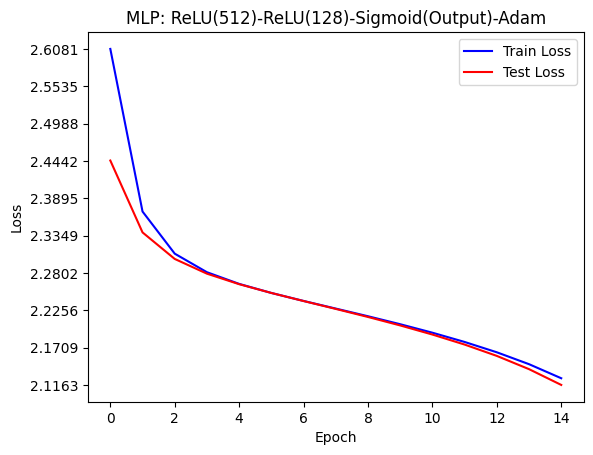

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1

# Weight and bias initialization
weights_sgd = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.039, mean=0.0)),  
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.055, mean=0.0)), 
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) 
}

weights_relu = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)), 
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0)) 
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# Use weights_relu for ReLU activations
weights = weights_relu

# MLP model with ReLU activations
@tf.function
def multilayer_perceptron(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out']), biases['out']))  # Keep sigmoid in output for classification probs
    return out_layer

# Optimizer and loss
optimizer = tf.optimizers.SGD(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy function
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Plotting function
def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

fig, ax = plt.subplots(1, 1)
plt.ion()

xs, ytrs, ytes = [], [], []

for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron(batch_x)
            loss = loss_fn(batch_y, logits)
        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)
    test_logits = multilayer_perceptron(mnist_test_images)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if epoch % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

# Final static plot
plt.ioff()
plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
             title="MLP: ReLU(512)-ReLU(128)-Sigmoid(Output)-Adam")

# Final accuracy
final_logits = multilayer_perceptron(mnist_test_images)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

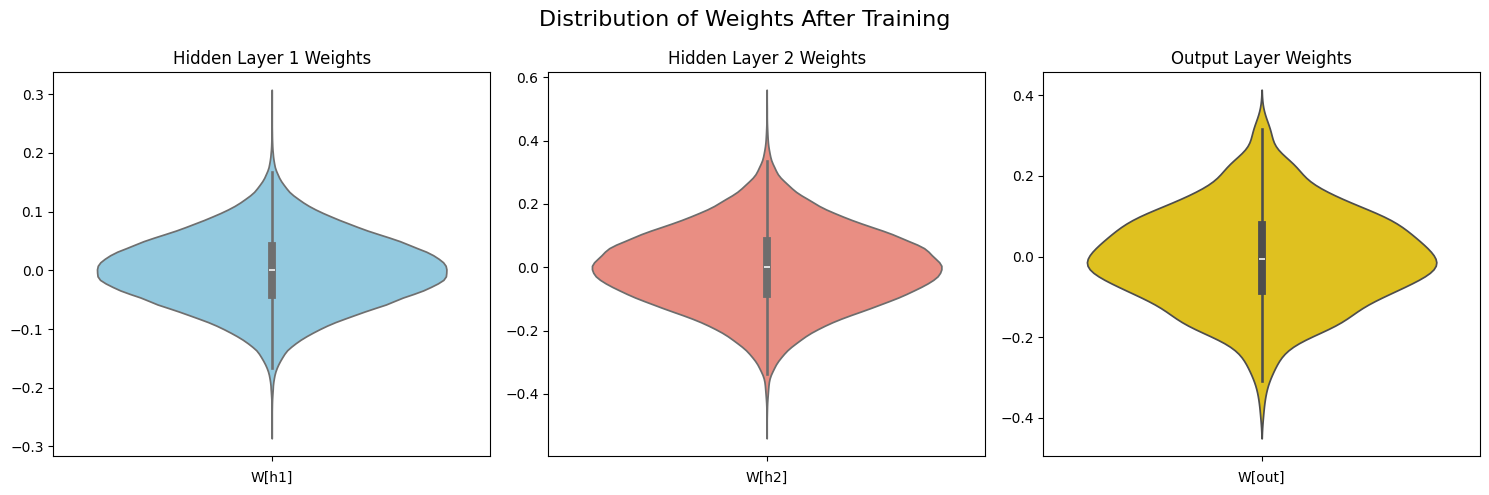

In [29]:

# Plot weight distributions
h1_w = weights_relu['h1'].numpy().flatten()
h2_w = weights_relu['h2'].numpy().flatten()
out_w = weights_relu['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

# Model 3: Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output)

## Adam

Epoch 01, Train Loss: 1.4434, Test Loss: 0.8642
Epoch 02, Train Loss: 0.6871, Test Loss: 0.5504
Epoch 03, Train Loss: 0.4925, Test Loss: 0.4254
Epoch 04, Train Loss: 0.3890, Test Loss: 0.3451
Epoch 05, Train Loss: 0.3118, Test Loss: 0.2769
Epoch 06, Train Loss: 0.2459, Test Loss: 0.2246
Epoch 07, Train Loss: 0.1934, Test Loss: 0.1854
Epoch 08, Train Loss: 0.1555, Test Loss: 0.1606
Epoch 09, Train Loss: 0.1289, Test Loss: 0.1413
Epoch 10, Train Loss: 0.1078, Test Loss: 0.1256
Epoch 11, Train Loss: 0.0918, Test Loss: 0.1186
Epoch 12, Train Loss: 0.0794, Test Loss: 0.1078
Epoch 13, Train Loss: 0.0685, Test Loss: 0.1015
Epoch 14, Train Loss: 0.0594, Test Loss: 0.0954
Epoch 15, Train Loss: 0.0516, Test Loss: 0.0885
Test Accuracy: 0.9752


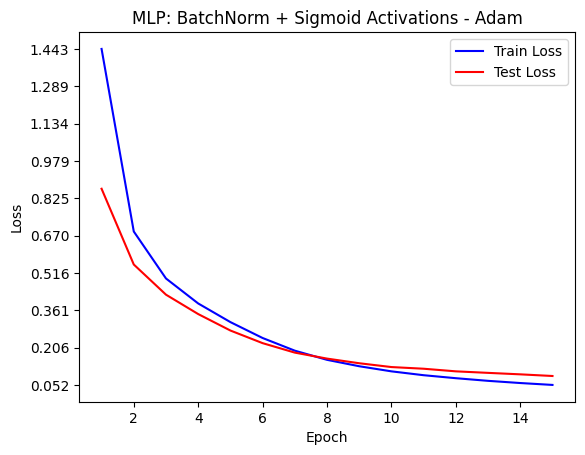

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1
epsilon = 1e-3

# Initialize weights and biases
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  # He Normal stddev for ReLU can be reused here
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# BatchNorm scale and beta variables (trainable)
scale = {
    's1': tf.Variable(tf.ones([n_hidden_1]), trainable=True),
    's2': tf.Variable(tf.ones([n_hidden_2]), trainable=True)
}

beta = {
    'b1': tf.Variable(tf.zeros([n_hidden_1]), trainable=True),
    'b2': tf.Variable(tf.zeros([n_hidden_2]), trainable=True)
}

# MLP with BatchNorm + Sigmoid activations on hidden layers
@tf.function
def multilayer_perceptron_batch(x, weights, biases, scale, beta):
    # Layer 1
    layer_1 = tf.matmul(x, weights['h1']) + biases['b1']
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1, axes=[0])
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta['b1'], scale['s1'], epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)

    # Layer 2
    layer_2 = tf.matmul(layer_1, weights['h2']) + biases['b2']
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, axes=[0])
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta['b2'], scale['s2'], epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)

    # Output layer (sigmoid)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Optimizer and loss function
optimizer = tf.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy calculation
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Dataset preparation
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# For live plotting
plt.ion()
fig, ax = plt.subplots(1, 1)
xs, ytrs, ytes = [], [], []

def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron_batch(batch_x, weights, biases, scale, beta)
            loss = loss_fn(batch_y, logits)
        variables = list(weights.values()) + list(biases.values()) + list(scale.values()) + list(beta.values())
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)

    test_logits = multilayer_perceptron_batch(mnist_test_images, weights, biases, scale, beta)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch + 1)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
                title="MLP: BatchNorm + Sigmoid Activations - Adam")

plt.ioff()

# Final accuracy
final_logits = multilayer_perceptron_batch(mnist_test_images, weights, biases, scale, beta)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

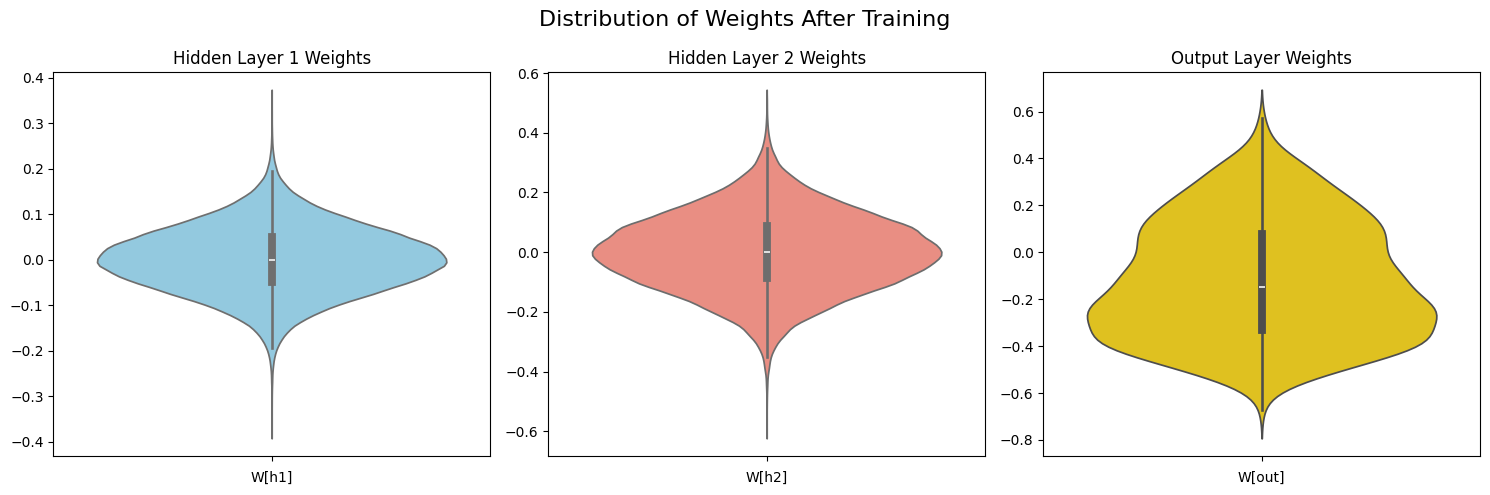

In [31]:
# Plot weight distributions
h1_w = weights['h1'].numpy().flatten()
h2_w = weights['h2'].numpy().flatten()
out_w = weights['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

## SGD

Epoch 01, Train Loss: 2.3919, Test Loss: 2.3813
Epoch 02, Train Loss: 2.3757, Test Loss: 2.3657
Epoch 03, Train Loss: 2.3608, Test Loss: 2.3514
Epoch 04, Train Loss: 2.3473, Test Loss: 2.3384
Epoch 05, Train Loss: 2.3348, Test Loss: 2.3264
Epoch 06, Train Loss: 2.3234, Test Loss: 2.3153
Epoch 07, Train Loss: 2.3129, Test Loss: 2.3051
Epoch 08, Train Loss: 2.3031, Test Loss: 2.2956
Epoch 09, Train Loss: 2.2940, Test Loss: 2.2867
Epoch 10, Train Loss: 2.2855, Test Loss: 2.2784
Epoch 11, Train Loss: 2.2776, Test Loss: 2.2706
Epoch 12, Train Loss: 2.2701, Test Loss: 2.2633
Epoch 13, Train Loss: 2.2631, Test Loss: 2.2563
Epoch 14, Train Loss: 2.2564, Test Loss: 2.2497
Epoch 15, Train Loss: 2.2500, Test Loss: 2.2434
Test Accuracy: 0.1242


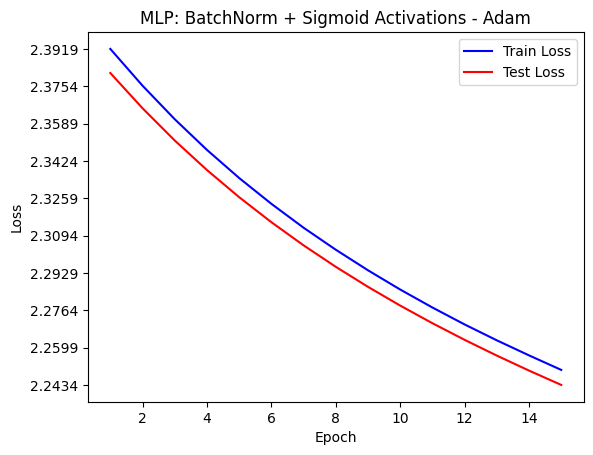

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1
epsilon = 1e-3

# Initialize weights and biases
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),  # He Normal stddev for ReLU can be reused here
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# BatchNorm scale and beta variables (trainable)
scale = {
    's1': tf.Variable(tf.ones([n_hidden_1]), trainable=True),
    's2': tf.Variable(tf.ones([n_hidden_2]), trainable=True)
}

beta = {
    'b1': tf.Variable(tf.zeros([n_hidden_1]), trainable=True),
    'b2': tf.Variable(tf.zeros([n_hidden_2]), trainable=True)
}

# MLP with BatchNorm + Sigmoid activations on hidden layers
@tf.function
def multilayer_perceptron_batch(x, weights, biases, scale, beta):
    # Layer 1
    layer_1 = tf.matmul(x, weights['h1']) + biases['b1']
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1, axes=[0])
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta['b1'], scale['s1'], epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)

    # Layer 2
    layer_2 = tf.matmul(layer_1, weights['h2']) + biases['b2']
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, axes=[0])
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta['b2'], scale['s2'], epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)

    # Output layer (sigmoid)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Optimizer and loss function
optimizer = tf.optimizers.SGD(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy calculation
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Dataset preparation
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# For live plotting
plt.ion()
fig, ax = plt.subplots(1, 1)
xs, ytrs, ytes = [], [], []

def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron_batch(batch_x, weights, biases, scale, beta)
            loss = loss_fn(batch_y, logits)
        variables = list(weights.values()) + list(biases.values()) + list(scale.values()) + list(beta.values())
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)

    test_logits = multilayer_perceptron_batch(mnist_test_images, weights, biases, scale, beta)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch + 1)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
                title="MLP: BatchNorm + Sigmoid Activations - Adam")

plt.ioff()

# Final accuracy
final_logits = multilayer_perceptron_batch(mnist_test_images, weights, biases, scale, beta)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

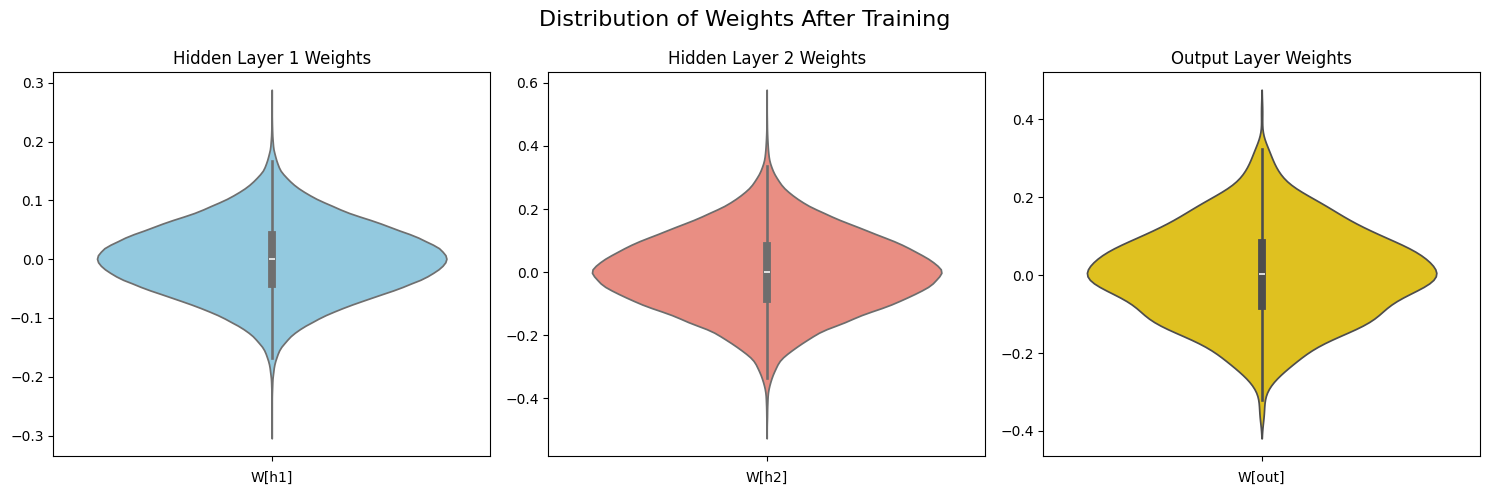

In [33]:
# Plot weight distributions
h1_w = weights['h1'].numpy().flatten()
h2_w = weights['h2'].numpy().flatten()
out_w = weights['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

# Model 4: Input - ReLu(512) - Dropout - ReLu(128)- Dropout -Sigmoid(output)

## Adam 

Epoch 01, Train Loss: 1.4942, Test Loss: 0.3496
Epoch 02, Train Loss: 0.4235, Test Loss: 0.1993
Epoch 03, Train Loss: 0.2672, Test Loss: 0.1553
Epoch 04, Train Loss: 0.2101, Test Loss: 0.1271
Epoch 05, Train Loss: 0.1736, Test Loss: 0.1138
Epoch 06, Train Loss: 0.1473, Test Loss: 0.1022
Epoch 07, Train Loss: 0.1335, Test Loss: 0.0952
Epoch 08, Train Loss: 0.1168, Test Loss: 0.0860
Epoch 09, Train Loss: 0.1051, Test Loss: 0.0810
Epoch 10, Train Loss: 0.0967, Test Loss: 0.0781
Epoch 11, Train Loss: 0.0862, Test Loss: 0.0735
Epoch 12, Train Loss: 0.0807, Test Loss: 0.0740
Epoch 13, Train Loss: 0.0743, Test Loss: 0.0688
Epoch 14, Train Loss: 0.0676, Test Loss: 0.0672
Epoch 15, Train Loss: 0.0635, Test Loss: 0.0666
Test Accuracy: 0.9814


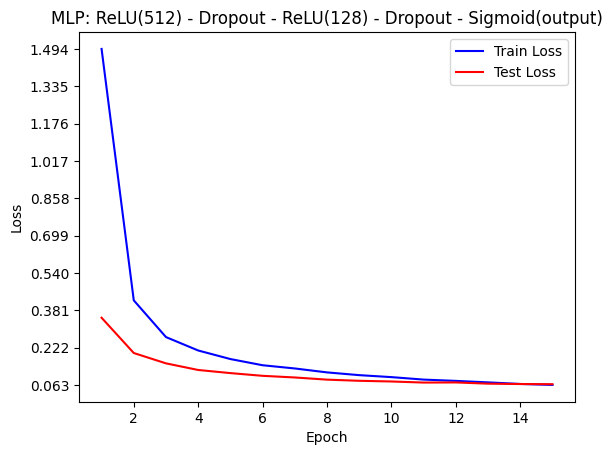

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1
dropout_rate = 0.3  # Dropout probability

# Initialize weights and biases (He normal stddev for ReLU)
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# MLP model with ReLU + Dropout + Sigmoid output
@tf.function
def multilayer_perceptron_dropout(x, weights, biases, training=True):
    # Layer 1
    layer_1 = tf.matmul(x, weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    if training:
        layer_1 = tf.nn.dropout(layer_1, rate=dropout_rate)

    # Layer 2
    layer_2 = tf.matmul(layer_1, weights['h2']) + biases['b2']
    layer_2 = tf.nn.relu(layer_2)
    if training:
        layer_2 = tf.nn.dropout(layer_2, rate=dropout_rate)

    # Output layer
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Optimizer and loss function
optimizer = tf.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy calculation
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Dataset preparation
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# For live plotting
plt.ion()
fig, ax = plt.subplots(1, 1)
xs, ytrs, ytes = [], [], []

def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron_dropout(batch_x, weights, biases, training=True)
            loss = loss_fn(batch_y, logits)
        variables = list(weights.values()) + list(biases.values())
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)

    # Eval on test set without dropout
    test_logits = multilayer_perceptron_dropout(mnist_test_images, weights, biases, training=False)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch + 1)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
                title="MLP: ReLU(512) - Dropout - ReLU(128) - Dropout - Sigmoid(output)")

plt.ioff()

# Final accuracy
final_logits = multilayer_perceptron_dropout(mnist_test_images, weights, biases, training=False)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

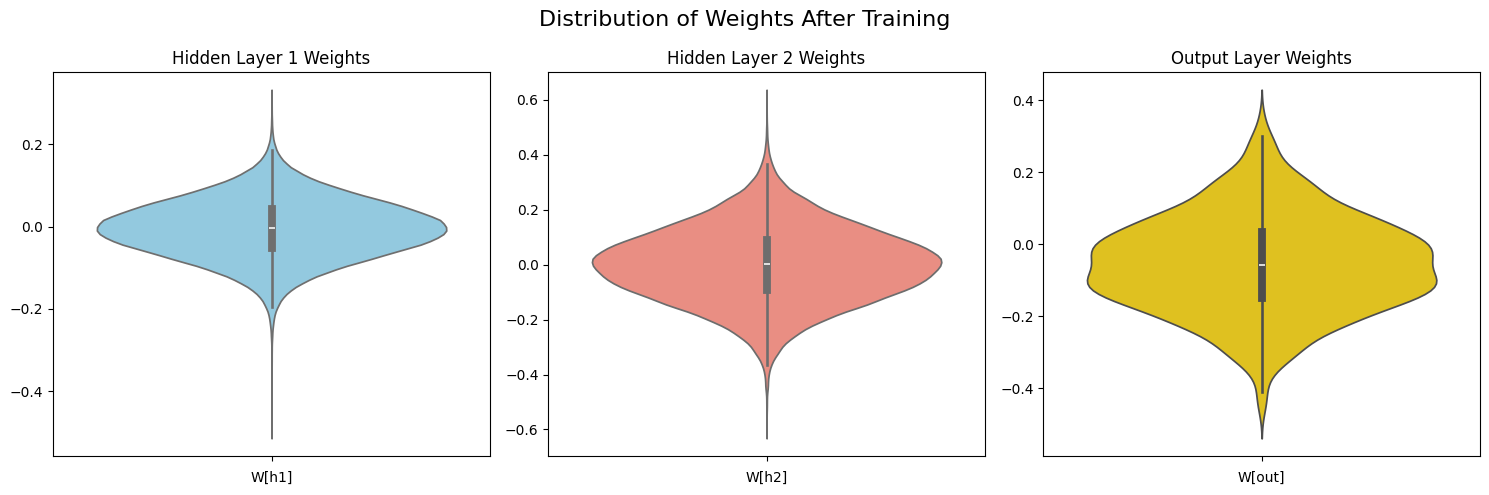

In [35]:
# Plot weight distributions
h1_w = weights['h1'].numpy().flatten()
h2_w = weights['h2'].numpy().flatten()
out_w = weights['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()

## SGD

Epoch 01, Train Loss: 2.8526, Test Loss: 2.3797
Epoch 02, Train Loss: 2.5374, Test Loss: 2.2752
Epoch 03, Train Loss: 2.4347, Test Loss: 2.2564
Epoch 04, Train Loss: 2.3705, Test Loss: 2.2525
Epoch 05, Train Loss: 2.3524, Test Loss: 2.2518
Epoch 06, Train Loss: 2.3285, Test Loss: 2.2519
Epoch 07, Train Loss: 2.3168, Test Loss: 2.2521
Epoch 08, Train Loss: 2.3059, Test Loss: 2.2520
Epoch 09, Train Loss: 2.2987, Test Loss: 2.2516
Epoch 10, Train Loss: 2.2912, Test Loss: 2.2510
Epoch 11, Train Loss: 2.2856, Test Loss: 2.2499
Epoch 12, Train Loss: 2.2852, Test Loss: 2.2487
Epoch 13, Train Loss: 2.2794, Test Loss: 2.2471
Epoch 14, Train Loss: 2.2764, Test Loss: 2.2452
Epoch 15, Train Loss: 2.2723, Test Loss: 2.2431
Test Accuracy: 0.1734


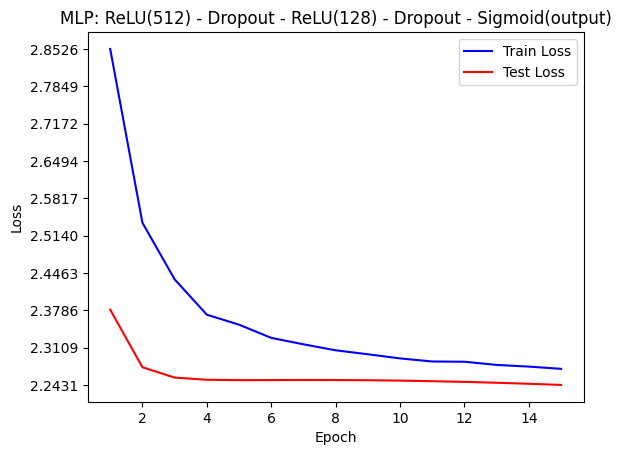

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
mnist_train_images = mnist_train_images.reshape(-1, 784)
mnist_test_images = mnist_test_images.reshape(-1, 784)

# One-hot encode the labels
num_classes = 10
mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, num_classes)
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, num_classes)

# Network Parameters
n_input = 784
n_hidden_1 = 512
n_hidden_2 = 128
n_classes = 10
learning_rate = 0.001
training_epochs = 15
batch_size = 1000
display_step = 1
dropout_rate = 0.3  # Dropout probability

# Initialize weights and biases (He normal stddev for ReLU)
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], stddev=0.062, mean=0.0)),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], stddev=0.125, mean=0.0)),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], stddev=0.120, mean=0.0))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

# MLP model with ReLU + Dropout + Sigmoid output
@tf.function
def multilayer_perceptron_dropout(x, weights, biases, training=True):
    # Layer 1
    layer_1 = tf.matmul(x, weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    if training:
        layer_1 = tf.nn.dropout(layer_1, rate=dropout_rate)

    # Layer 2
    layer_2 = tf.matmul(layer_1, weights['h2']) + biases['b2']
    layer_2 = tf.nn.relu(layer_2)
    if training:
        layer_2 = tf.nn.dropout(layer_2, rate=dropout_rate)

    # Output layer
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Optimizer and loss function
optimizer = tf.optimizers.SGD(learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Accuracy calculation
def compute_accuracy(logits, labels):
    correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Dataset preparation
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# For live plotting
plt.ion()
fig, ax = plt.subplots(1, 1)
xs, ytrs, ytes = [], [], []

def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b', 'r']):
    ax.clear()
    ax.plot(x, y, colors[0], label="Train Loss")
    ax.plot(x, y_1, colors[1], label="Test Loss")
    ax.legend()
    ax.set_title(title)
    ax.set_yticks(ticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.figure.canvas.draw()
    ax.figure.canvas.flush_events()

# Training loop
for epoch in range(training_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            logits = multilayer_perceptron_dropout(batch_x, weights, biases, training=True)
            loss = loss_fn(batch_y, logits)
        variables = list(weights.values()) + list(biases.values())
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        epoch_loss += loss.numpy()

    epoch_loss /= len(train_dataset)

    # Eval on test set without dropout
    test_logits = multilayer_perceptron_dropout(mnist_test_images, weights, biases, training=False)
    test_loss = loss_fn(mnist_test_labels, test_logits).numpy()

    xs.append(epoch + 1)
    ytrs.append(epoch_loss)
    ytes.append(test_loss)

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:02d}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    plt_dynamic(xs, ytrs, ytes, ax, ticks=np.linspace(min(ytrs + ytes), max(ytrs + ytes), 10),
                title="MLP: ReLU(512) - Dropout - ReLU(128) - Dropout - Sigmoid(output)")

plt.ioff()

# Final accuracy
final_logits = multilayer_perceptron_dropout(mnist_test_images, weights, biases, training=False)
acc = compute_accuracy(final_logits, mnist_test_labels)
print("Test Accuracy:", acc.numpy())
plt.show()

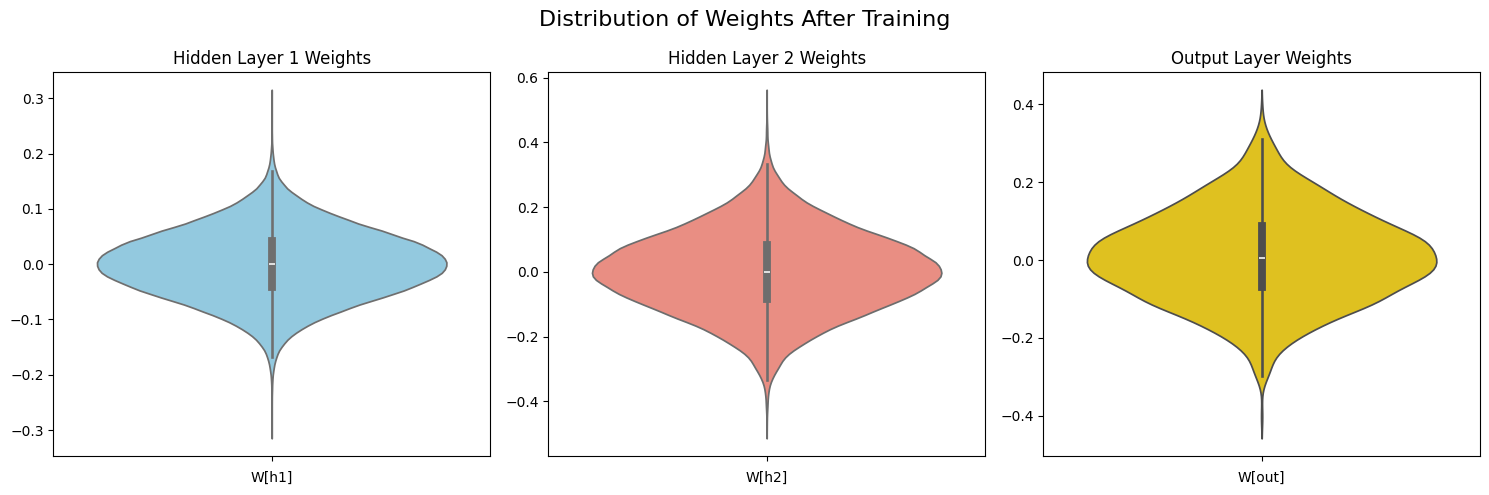

In [39]:
# Plot weight distributions
h1_w = weights['h1'].numpy().flatten()
h2_w = weights['h2'].numpy().flatten()
out_w = weights['out'].numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Weights After Training", fontsize=16)

sns.violinplot(y=h1_w, ax=axes[0], color='skyblue')
axes[0].set_title("Hidden Layer 1 Weights")
axes[0].set_xlabel("W[h1]")

sns.violinplot(y=h2_w, ax=axes[1], color='salmon')
axes[1].set_title("Hidden Layer 2 Weights")
axes[1].set_xlabel("W[h2]")

sns.violinplot(y=out_w, ax=axes[2], color='gold')
axes[2].set_title("Output Layer Weights")
axes[2].set_xlabel("W[out]")

plt.tight_layout()
plt.show()